## Measure bias from Color Gradient using moments
- shape measurements bias of galaxy with CG with hsm package of galsim is high
- we compare the values of galaxy with CG and effective galaxy(without CG, Semboloni2013)
- hsm parametrs are almost identical, but ellipticity difer by almost 25%
- input weight fn does not have an effect since adaptive moments are always used 
- m_CG ~ -0.024


In [189]:
%matplotlib inline
#%reset
import galsim
import matplotlib.pyplot as plt
import numpy as np
from chrom_objects import *
import short_cut_fns as sc

In [193]:
ls


Euclid filter.ipynb                hsm.ipynb
README.md                          mom measure.ipynb
Sem simplified-Copy1.ipynb         short_cut_fns.py
Sem simplified.ipynb               short_cut_fns.pyc
Sem-Copy1.ipynb                    simple exercise_final-Copy1.ipynb
Sem.ipynb                          simple exercise_final.ipynb
Untitled.ipynb                     simple_blue_SED.txt
chrom_objects.py                   simple_filter.txt
chrom_objects.pyc                  simple_red_SED.txt
data/                              whole_filter.txt
euclid_sem.txt


In [194]:
# Read SED from galsim data
# Flux density normalized to 1 at 550nm
datapath = 'data/'
SED_names = ['CWW_E_ext', 'CWW_Sbc_ext','CWW_Scd_ext', 'CWW_Im_ext']
SEDs = {}
for SED_name in SED_names:
    SED_filename = datapath+'{}.sed'.format(SED_name)
    SED = galsim.SED(SED_filename, wave_type='Ang')
    SEDs[SED_name] = SED.withFluxDensity(target_flux_density=1.0, wavelength=550) 
    
# euclid filetr used in Semboloni     
eu_filter=galsim.Bandpass('euclid_sem.txt').thin(rel_err=1e-4)      
red_SED=SEDs['CWW_E_ext']
blue_SED=SEDs['CWW_Im_ext']

In [102]:
# function to create psf convolved with galaxy image
def im_chr_test(gal,psf,im_param):
    conv = galsim.Convolve([gal, psf])
    gal_im=conv.drawImage(im_param.filt,image=im_param.draw_image())
    return gal_im

#class that stores image parameters 
class simple_image:
    def __init__(self,
                 I_size=[128,128], 
                 pixel_scale=None,
                 method='auto',
                 T_fn=None
                ):
        """Class to store parametrs used to draw images
        I_size     : Size of image; default=[128,128]
        pixel_scale: Scale to draw the image, in arcsec/pixel;default lets galsim pick scale depending on Nyquist scale
        method: """
        self.size=I_size
        self.scale=pixel_scale
        self.method=method
        self.filt=T_fn
    def draw_image(self):
        return galsim.ImageF(self.size[0],self.size[1],scale=self.scale)

In [184]:
I_size=2**8              # Image size
pixel_scale = 0.05/2       #pixel scale
w1=0.102                  
base_wavelength=800.
B1_re_b=0.17              # bulge r_e
B1_re_d=1.2               # disk r_e
B1_n_b=1.5                # bulge serseic  n 
B1_n_d=1.                 # disk sersic n
gal_flux=1e3              # galaxy flux
alpha=1                   # wavelength dependance of psf
sigma_800=w1              # psf sigma
redshift=0.3               # redshift of SED
t_b_flux=0.45               # bulge to total flux ratio

In [185]:
'''w=galsim.Gaussian(sigma=2)
img = galsim.ImageF(I_size, I_size, scale=pixel_scale)
weight_fn=w.drawImage(image=img)
            #w1=weight_fn.flatten()
            #w1[w1<0]=0.
            #weight_fn=w1.reshape(I_size, I_size)
weight_fn.fill(1)'''

'w=galsim.Gaussian(sigma=2)\nimg = galsim.ImageF(I_size, I_size, scale=pixel_scale)\nweight_fn=w.drawImage(image=img)\n            #w1=weight_fn.flatten()\n            #w1[w1<0]=0.\n            #weight_fn=w1.reshape(I_size, I_size)\nweight_fn.fill(1)'

In [186]:
b_SED=red_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
d_SED=blue_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
c_SED=(t_b_flux*b_SED +((1-t_b_flux)*d_SED))
#c_SED=b_SED
#set image parametrs
image_param=simple_image([I_size,I_size],pixel_scale,T_fn=eu_filter)

# PSF
psf=psf_chr(base_wavelength,alpha,sigma=sigma_800)
star = (galsim.Gaussian(fwhm=1.0e-8,flux=1))*c_SED
#draw psf image for shear estimation
psf_im=im_chr_test(star,psf,image_param)
#draw psf image to get effective psf
conv1=galsim.Convolve([psf,star])
#increase resolution when drawing
image_param2=simple_image([I_size*4,I_size*4],pixel_scale/4,method='no_pixel',T_fn=eu_filter)
psf_im_np=conv1.drawImage(eu_filter,method=image_param2.method,image=image_param2.draw_image())
psf2=galsim.InterpolatedImage(psf_im_np)  

#Galaxy  with CG  (_cg)
galaxy_cg=gal_chr(B1_re_b,B1_re_d,B1_n_b,B1_n_d,gal_flux,t_b_flux,b_SED=b_SED,d_SED=d_SED)
#galaxy_cg=gal_chr_gaus(B1_re_b,B1_re_d,gal_flux,t_b_flux,b_SED=b_SED,d_SED=d_SED)


#Galxy without CG: effective _e   ### Deconvolved galaxy Semboloni
#deconvolve effective psf with the psf convolved cg galaxy          
inv_psf = galsim.Deconvolve(psf2)
conv=galsim.Convolve([galaxy_cg,psf])
deconv_gal = galsim.Convolve(inv_psf, conv)    
deconv_img=deconv_gal.drawImage(eu_filter,image=image_param2.draw_image(),method=image_param2.method)
galaxy_e=galsim.InterpolatedImage(deconv_img)*c_SED


galaxy_cg=galaxy_cg.shear(g1=0.01,g2=0.01)
galaxy_e=galaxy_e.shear(g1=0.01,g2=0.01)
gal1_im=im_chr_test(galaxy_cg,psf,image_param)
gal2_im=im_chr_test(galaxy_e,psf,image_param)
new_params = galsim.hsm.HSMParams(max_moment_nsig2=10000,max_mom2_iter=1000000)
result1  = galsim.hsm.EstimateShear(gal1_im,psf_im,shear_est='REGAUSS',
                                    precision=8e-07,strict=True,
                                    guess_x_centroid=127.,guess_y_centroid=127.,
                                    guess_sig_gal=50.0, guess_sig_PSF=5,
                                    hsmparams = new_params)
result2  = galsim.hsm.EstimateShear(gal2_im,psf_im,shear_est='REGAUSS',
                                    strict=True)#,weight=weight)

In [187]:
a1=galsim.Shear(e1=result1.corrected_e1,e2=result1.corrected_e2)
a2=galsim.Shear(e1=result2.corrected_e1,e2=result2.corrected_e2)
print 'corrected g,(CG,noCG)', [a1.g1,a1.g2],[a2.g1,a2.g2]
print 'm_cg                 ', [a1.g1/a2.g1-1, a1.g2/a2.g2-1]

b1,b2=result1.observed_shape,result2.observed_shape
print 'observed g,(CG,noCG) ', [b1.g1,b1.g2],[b2.g1,b2.g2]
print 'm_cg                 ', [b1.g1/b2.g1-1, b1.g2/b2.g2-1]

#sigma=d|et(M)|**1/4
print 'moments sigma        ',result1.moments_sigma*pixel_scale,result2.moments_sigma*pixel_scale
#amplitude~flux/2 
print 'amplitude            ', result1.moments_amp,result2.moments_amp
print 'resolution(1 perfect)',result1.resolution_factor,result2.resolution_factor
print 'no iterations        ',result1.moments_n_iter,result1.moments_n_iter
print 'rho4                 ',result1.moments_rho4,result1.moments_rho4

corrected g,(CG,noCG) [0.009742621644067721, 0.009746603804202393] [0.009986097962010564, 0.009990427613063759]
m_cg                  [-0.024381527085863164, -0.02440574300769016]
observed g,(CG,noCG)  [0.00603804208404252, 0.006044370353321481] [0.006188206745497287, 0.006194639431587123]
m_cg                  [-0.024266264465716336, -0.024257921695878593]
moments sigma         0.175992417336 0.175991344452
amplitude             54438.7773438 54435.859375
resolution(1 perfect) 0.734222173691 0.734220921993
no iterations         43 43
rho4                  2.34843213848 2.34843213848


In [ ]:
x=[-0.023405918665950876,-0.02421820937760355,-0.024381527085863164]
y=[0.1,0.05,0.025]


In [154]:
result1.moments_centroid # is correct for .FindAdaptiveMom()

PositionD(x=0.0, y=0.0)

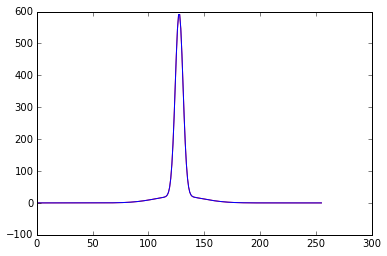

In [162]:
plt.plot(gal1_im.array[:][128],'r')
plt.plot(gal2_im.array[:][128],'b')
#plt.xlim([100,150])

('flux', 104641.95, 104641.96)


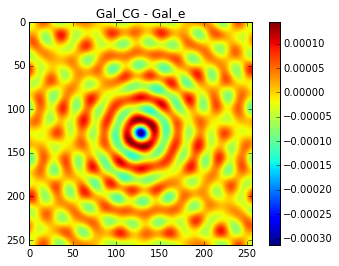

In [167]:
dif_im=np.array(gal1_im.array)-np.array(gal2_im.array)
plt.imshow(dif_im)
plt.colorbar()
print('flux',gal1_im.array.sum(),gal2_im.array.sum())
plt.title('Gal_CG - Gal_e')


In [155]:
a=gal1_im.FindAdaptiveMom()
b=gal2_im.FindAdaptiveMom()

In [156]:
a.moments_sigma*pixel_scale,b.moments_sigma*pixel_scale

(0.1786238193511963, 0.17862389087677003)

In [157]:
a.observed_shape,b.observed_shape

(Shear(g1=0.00601203907333, g2=0.00601825039318),
 Shear(g1=0.00616034719272, g2=0.00616674598529))

In [158]:
a.observed_shape.g1/b.observed_shape.g1-1

-0.02407463650153563

In [159]:
a.moments_amp,b.moments_amp

(46483.91796875, 46483.95703125)

In [117]:
psf_im.array.sum()

101.25861

In [118]:
54554-46483

8071